In [533]:
# load package
import pandas as pd
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error #均方误差
from sklearn.metrics import mean_absolute_error #平方绝对误差
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
import scipy
import math
import geopandas as gp
import numpy as np
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

In [619]:
# 评价指标
def evaluation(real_y, prediction_y):

    # rmse  mae  r2  r
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(real_y, prediction_y)
    print("R-squared", r_value**2)
    print("R", r_value)

    mae = mean_absolute_error(real_y, prediction_y)
    print("mae", mae)

    rmse = mean_squared_error(real_y, prediction_y) ** 0.5
    print("rmse", rmse)

    ############# 设置图例并且设置图例的字体及大小 #############
    font1 = {'family': 'Times New Roman',
            'weight': 'normal',
            'size': 15,
            }
    
    figsize = 20,16
    figure, ax = plt.subplots(figsize=figsize)
    level = [50000, 5500, 1000, 200, 100, 80, 60, 40,20]
    for i in range(len(level)):

        plt.subplot(3,3,i+1)
        plt.scatter(real_y, prediction_y, c='b', marker='o', label='', s=10, alpha=0.7, zorder=20)
        plt.plot([0, 50000], [0, 50000], '--', color='black', label='', linewidth=1.0)
        
        ############# 设置坐标刻度值的大小以及刻度值的字体 #############
        plt.xlim(0, level[i])
        plt.ylim(0, level[i])
        plt.tick_params(labelsize=15)
        
        plt.ylabel('prediction', font1)
        plt.xlabel('real', font1)

        # x，y轴设置显示刻度一致
        ax = plt.gca()
        ax.set_aspect(1)
    
    plt.show()


# 疫情建模
def covid_all_predict(df, index, threshold):

    '''
    df = df[['id','location',
    'rhMean','rhMax','rhMin',
    't2mMean','t2mMax','t2mMin',
    'moveInMean','moveInMax','moveInMin',
    'moveOutMea','moveOutMax','moveOutMin',
    'travelMean','travelMax','travelMin',
    'WuhanMean','WuhanMax','WuhanMin',
    'confirmed','confirmLog','npp']]
    '''
    
    df = df[['id','location',
    'rhMean',
    't2mMean',
    'moveInMean',
    'moveOutMea',
    'travelMean',
    'WuhanMean',
    'confirmed','confirmLog', 'X', 'Y']]

    real_y = []
    prediction_y = []

    df_predict = []

    case = []

    for i in range(len(index)):

        train_df = df.iloc[index[i][0], :]
        test_df = df.iloc[index[i][1], :]

        df_predict.extend(test_df['id'].to_list())

        train_y_log = train_df['confirmLog'].values.reshape((-1,1))
        train_y = train_df['confirmed'].values.reshape((-1,1)).flatten()
        u = train_df['X']
        v = train_df['Y']
        cal_coords = list(zip(u,v))

        train_x = train_df.drop(['id', 'location', 'confirmLog', 'confirmed', 'X', 'Y'], axis=1).values

        test_y = test_df['confirmed'].values.reshape((-1,1)).flatten()
        test_x = test_df.drop(['id', 'location', 'confirmLog', 'confirmed', 'X', 'Y'], axis=1).values
        
        u = test_df['X']
        v = test_df['Y']
        pred_coords = list(zip(u,v))
        
        #Calibrate GWR model
        gwr_selector = Sel_BW(np.array(cal_coords), train_y_log, train_x)
        gwr_bw = gwr_selector.search(criterion = 'AICc')
        print(gwr_bw)
        model = GWR(np.array(cal_coords), train_y_log, train_x, gwr_bw)
        gwr_results = model.fit()

        scale = gwr_results.scale
        residuals = gwr_results.resid_response

        predict_ytrain_log = model.predict(np.array(cal_coords), train_x, scale, residuals).predictions.flatten()
        predict_ytrain = np.trunc(np.exp(predict_ytrain_log) - 1)

        predict_ytest_log = model.predict(np.array(pred_coords), test_x, scale, residuals).predictions.flatten()
        predict_ytest = np.trunc(np.exp(predict_ytest_log) - 1)
        
        
        real_y.extend(test_y)
        prediction_y.extend(predict_ytest)

        print("train fold " + str(i+1))
        print("预测误差较大城市，绝对值误差阈值设置为" + str(threshold))
        predict_train_y = list(predict_ytrain)
        train_yy = list(train_y)
        for j in range(len(train_df)):
            if abs(train_yy[j]-predict_train_y[j])>threshold:
                print(train_df.iloc[j, 1] + "   real: " + str(train_yy[j]) + "   pre:" + str(predict_train_y[j]))
                #case.append(train_df.iloc[j, 0])

        evaluation(train_yy, predict_train_y)


        print("#########################################")
        print("test fold " + str(i+1))
        print("预测误差较大城市，绝对值误差阈值设置为" + str(threshold))
        predict_test_y = list(predict_ytest)
        test_yy = list(test_y)
        for j in range(len(test_df)):
            if abs(test_yy[j]-predict_test_y[j])>threshold:
                print(test_df.iloc[j, 1] + "   real: " + str(test_yy[j]) + "   pre:" + str(predict_test_y[j]))
                case.append(test_df.iloc[j, 0])

        evaluation(test_yy, predict_test_y)
    

    df_predict = pd.DataFrame(df_predict)
    df_predict.columns = ['id']
    df_predict['predict'] = prediction_y

    print("************* cv evaluation ***************")
    evaluation(real_y, prediction_y)

    return case, df_predict

In [620]:
# 所有城市全时间段建模

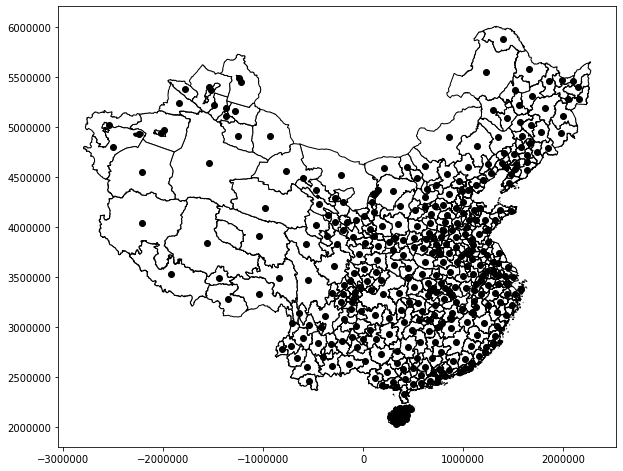

In [621]:
df = gp.GeoDataFrame.from_file("../shp/china_city_distinct_COVID19.shp")

fig, ax = plt.subplots(figsize=(10,10))
df.plot(ax=ax, **{'edgecolor':'black', 'facecolor':'white'})
df.centroid.plot(ax=ax, c='black')

66.0
train fold 1
预测误差较大城市，绝对值误差阈值设置为50
天津市   real: 174   pre:74.0
哈尔滨市   real: 198   pre:125.0
上海市   real: 516   pre:627.0
宁波市   real: 157   pre:71.0
金华市   real: 55   pre:119.0
台州市   real: 146   pre:57.0
亳州市   real: 108   pre:18.0
南昌市   real: 230   pre:158.0
新余市   real: 130   pre:76.0
抚州市   real: 72   pre:19.0
上饶市   real: 123   pre:42.0
济宁市   real: 260   pre:43.0
郑州市   real: 157   pre:300.0
商丘市   real: 91   pre:37.0
武汉市   real: 50006   pre:52283.0
黄石市   real: 1015   pre:602.0
十堰市   real: 672   pre:381.0
襄阳市   real: 1175   pre:635.0
鄂州市   real: 1394   pre:2053.0
荆门市   real: 928   pre:486.0
咸宁市   real: 836   pre:477.0
随州市   real: 1307   pre:591.0
恩施土家族苗族自治州   real: 252   pre:197.0
仙桃市   real: 575   pre:896.0
天门市   real: 496   pre:287.0
长沙市   real: 242   pre:353.0
邵阳市   real: 102   pre:31.0
广州市   real: 435   pre:719.0
珠海市   real: 103   pre:30.0
甘孜藏族自治州   real: 78   pre:3.0
昆明市   real: 53   pre:130.0
R-squared 0.9991167871374839
R 0.9995582960175379
mae 42.34166666666667
rmse 176.19241376

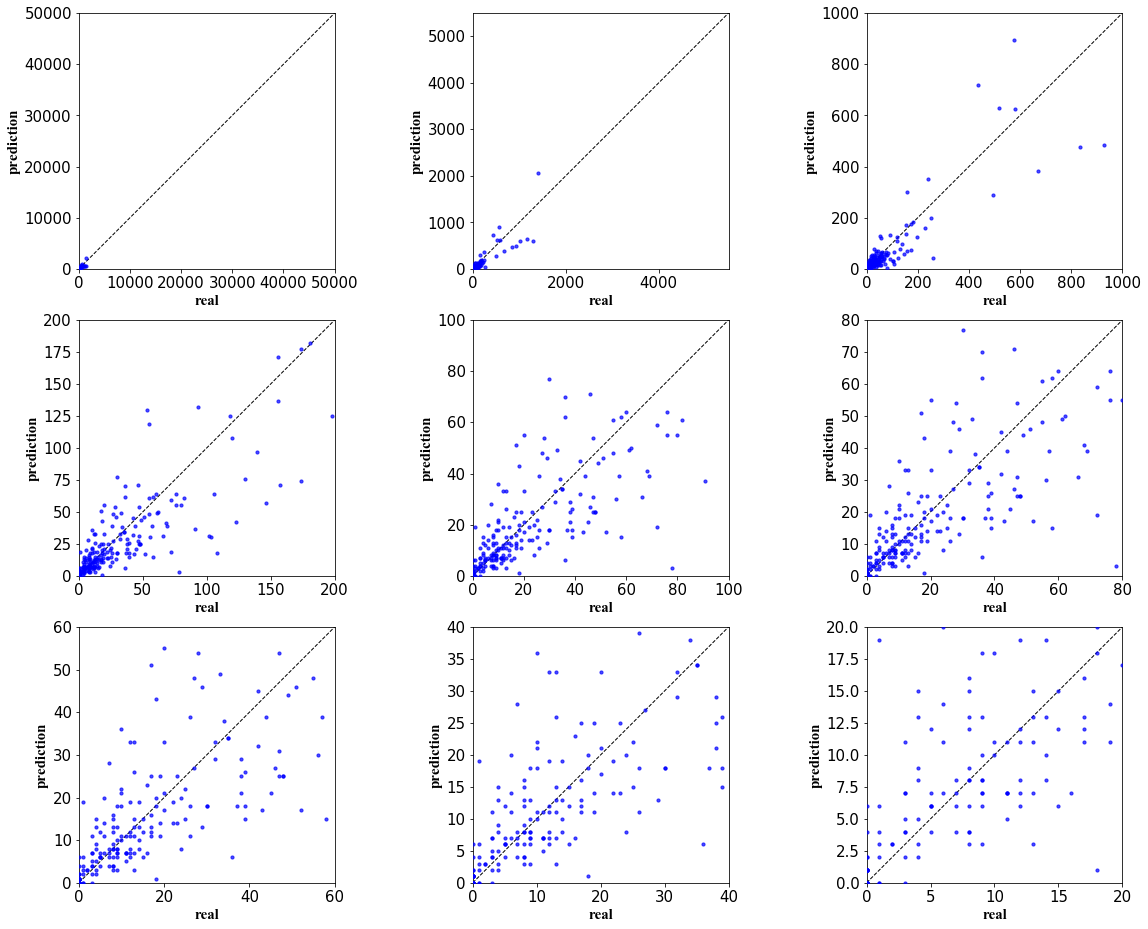

#########################################
test fold 1
预测误差较大城市，绝对值误差阈值设置为50
北京市   real: 580   pre:1721.0
苏州市   real: 87   pre:249.0
温州市   real: 504   pre:183.0
蚌埠市   real: 160   pre:50.0
安庆市   real: 83   pre:22.0
阜阳市   real: 155   pre:47.0
赣州市   real: 76   pre:21.0
宜昌市   real: 931   pre:645.0
孝感市   real: 3518   pre:5349.0
荆州市   real: 1580   pre:1347.0
黄冈市   real: 2907   pre:3858.0
潜江市   real: 198   pre:635.0
神农架林区   real: 11   pre:149.0
深圳市   real: 450   pre:625.0
东莞市   real: 100   pre:265.0
成都市   real: 155   pre:1515.0
贵阳市   real: 36   pre:150.0
咸阳市   real: 17   pre:90.0
渭南市   real: 15   pre:67.0
R-squared 0.9087928433068356
R 0.9533062694154674
mae 71.39669421487604
rmse 257.28228379295575


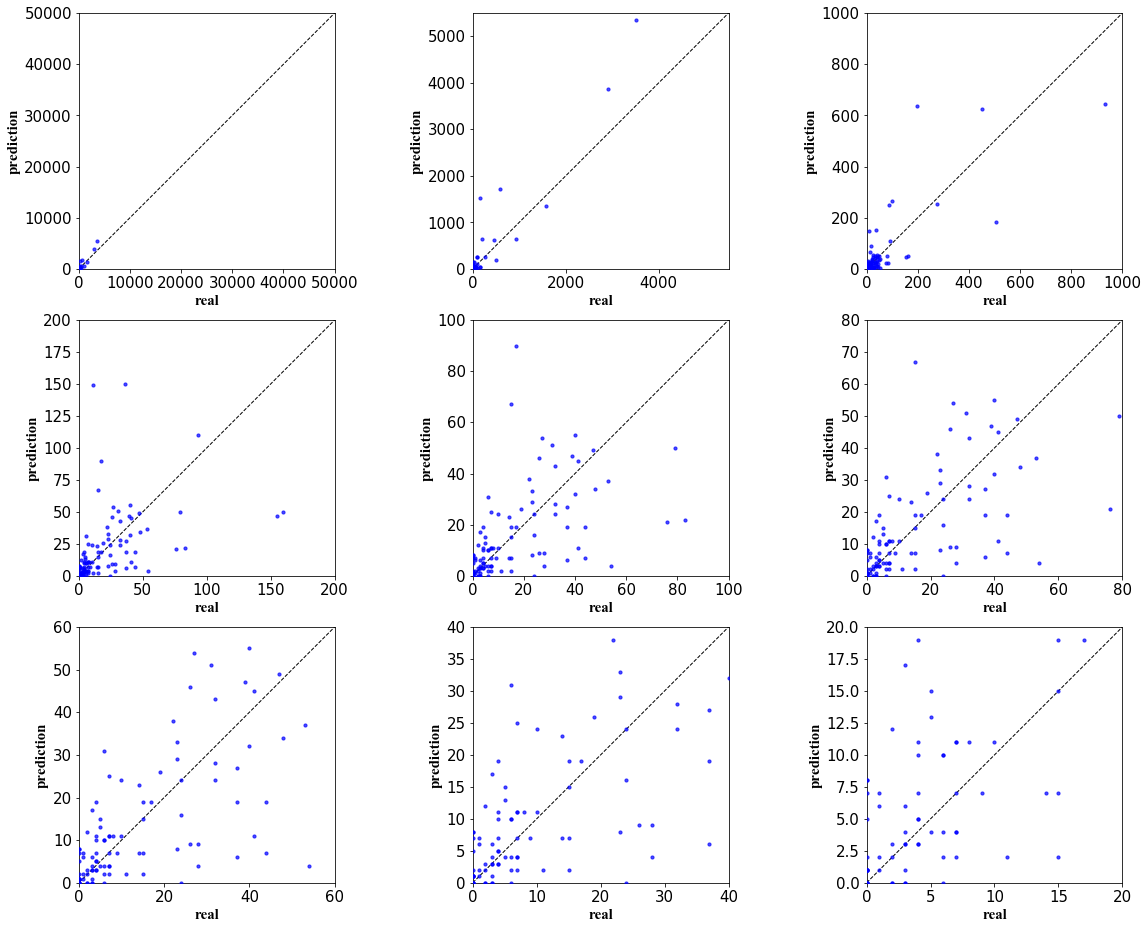

70.0
train fold 2
预测误差较大城市，绝对值误差阈值设置为50
温州市   real: 504   pre:194.0
台州市   real: 146   pre:47.0
丽水市   real: 17   pre:68.0
合肥市   real: 174   pre:273.0
蚌埠市   real: 160   pre:51.0
安庆市   real: 83   pre:31.0
阜阳市   real: 155   pre:64.0
亳州市   real: 108   pre:21.0
南昌市   real: 230   pre:162.0
上饶市   real: 123   pre:38.0
济宁市   real: 260   pre:45.0
郑州市   real: 157   pre:249.0
南阳市   real: 156   pre:105.0
黄石市   real: 1015   pre:383.0
宜昌市   real: 931   pre:244.0
荆门市   real: 928   pre:351.0
孝感市   real: 3518   pre:2973.0
荆州市   real: 1580   pre:1025.0
黄冈市   real: 2907   pre:5530.0
随州市   real: 1307   pre:372.0
潜江市   real: 198   pre:397.0
长沙市   real: 242   pre:430.0
邵阳市   real: 102   pre:28.0
岳阳市   real: 156   pre:97.0
广州市   real: 435   pre:648.0
珠海市   real: 103   pre:27.0
东莞市   real: 100   pre:169.0
重庆市   real: 579   pre:428.0
成都市   real: 155   pre:208.0
甘孜藏族自治州   real: 78   pre:2.0
R-squared 0.7632608223510607
R 0.8736479968219814
mae 44.767634854771785
rmse 203.5803082538036


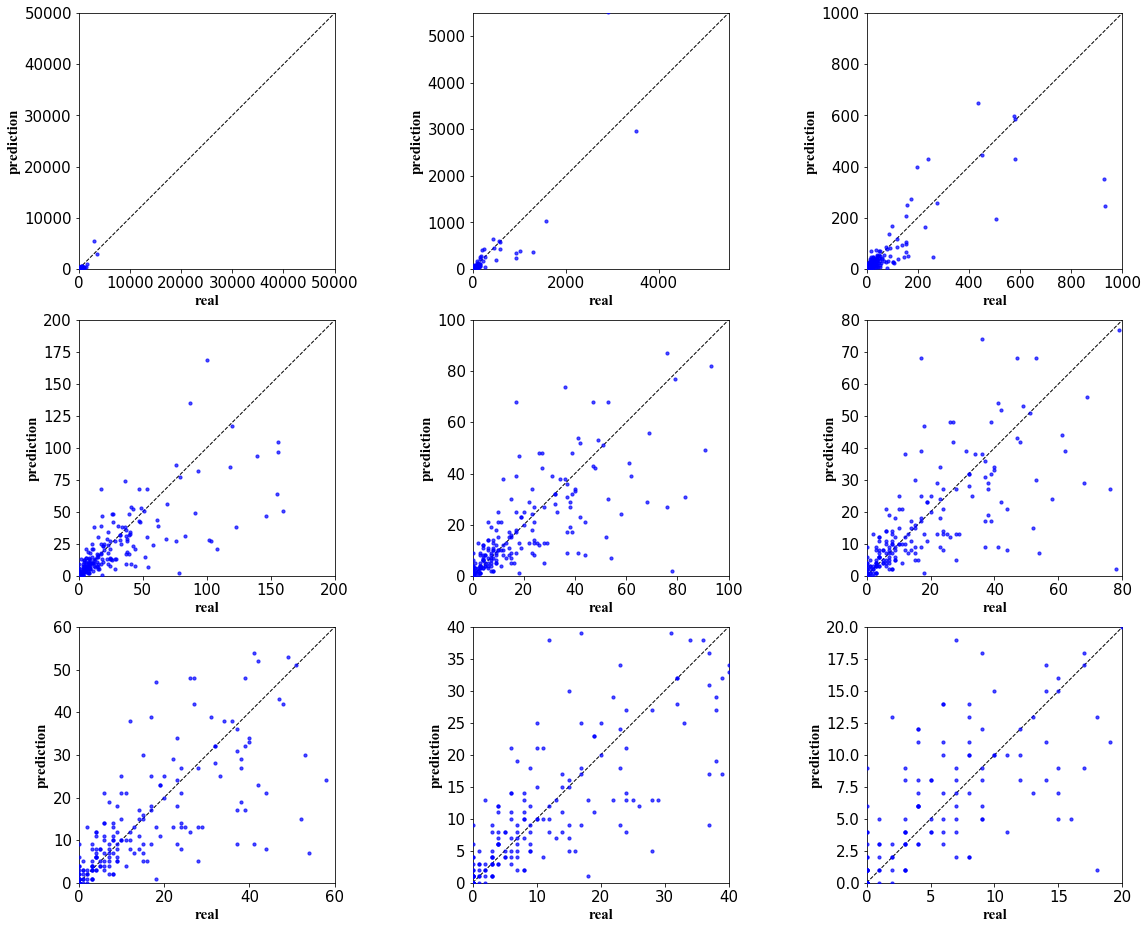

#########################################
test fold 2
预测误差较大城市，绝对值误差阈值设置为50
天津市   real: 174   pre:76.0
哈尔滨市   real: 198   pre:17.0
上海市   real: 516   pre:253.0
南京市   real: 93   pre:249.0
杭州市   real: 181   pre:411.0
宁波市   real: 157   pre:44.0
湖州市   real: 10   pre:62.0
金华市   real: 55   pre:143.0
滁州市   real: 13   pre:78.0
新余市   real: 130   pre:41.0
宜春市   real: 106   pre:47.0
抚州市   real: 72   pre:15.0
武汉市   real: 50006   pre:35288.0
十堰市   real: 672   pre:153.0
襄阳市   real: 1175   pre:337.0
鄂州市   real: 1394   pre:1224.0
咸宁市   real: 836   pre:312.0
恩施土家族苗族自治州   real: 252   pre:121.0
天门市   real: 496   pre:229.0
R-squared 0.9994443387279514
R 0.999722130758318
mae 164.16666666666666
rmse 1348.5692418263143


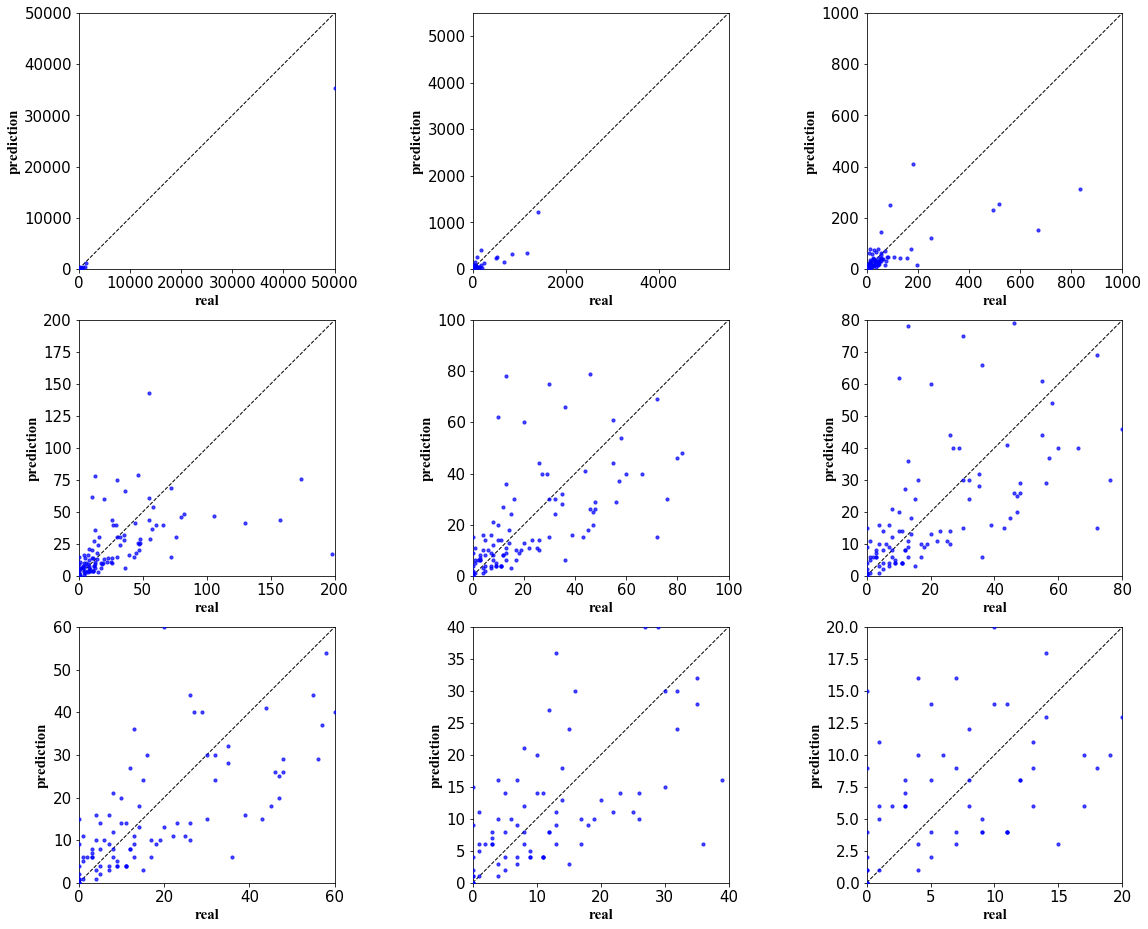

64.0
train fold 3
预测误差较大城市，绝对值误差阈值设置为50
北京市   real: 580   pre:776.0
天津市   real: 174   pre:70.0
上海市   real: 516   pre:334.0
南京市   real: 93   pre:220.0
苏州市   real: 87   pre:142.0
杭州市   real: 181   pre:304.0
宁波市   real: 157   pre:53.0
温州市   real: 504   pre:210.0
金华市   real: 55   pre:139.0
蚌埠市   real: 160   pre:45.0
安庆市   real: 83   pre:31.0
阜阳市   real: 155   pre:46.0
南平市   real: 20   pre:73.0
新余市   real: 130   pre:55.0
抚州市   real: 72   pre:20.0
武汉市   real: 50006   pre:49893.0
十堰市   real: 672   pre:172.0
宜昌市   real: 931   pre:340.0
襄阳市   real: 1175   pre:423.0
鄂州市   real: 1394   pre:1330.0
孝感市   real: 3518   pre:3320.0
荆州市   real: 1580   pre:1187.0
黄冈市   real: 2907   pre:5092.0
咸宁市   real: 836   pre:304.0
恩施土家族苗族自治州   real: 252   pre:129.0
潜江市   real: 198   pre:358.0
天门市   real: 496   pre:158.0
深圳市   real: 450   pre:540.0
R-squared 0.9972635241856537
R 0.9986308247724249
mae 39.87551867219917
rmse 169.14140024845574


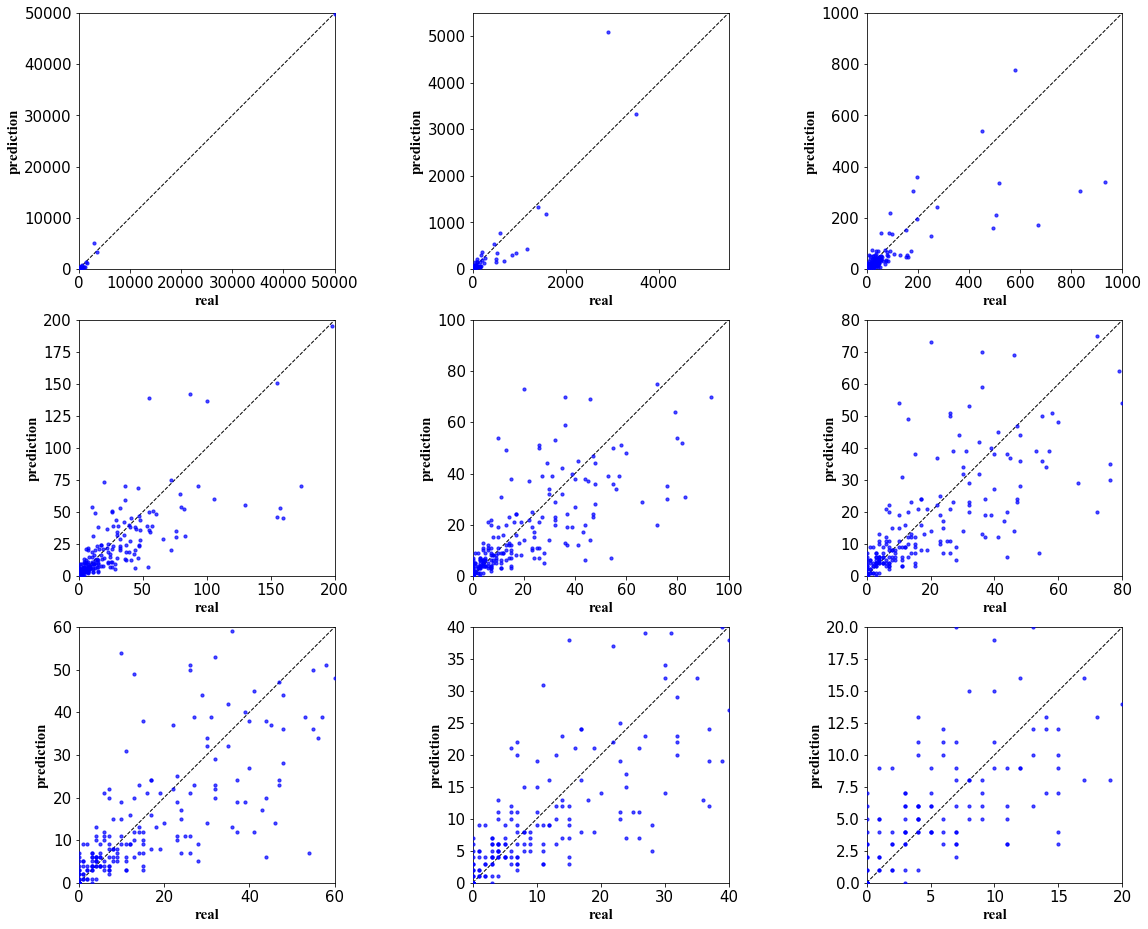

#########################################
test fold 3
预测误差较大城市，绝对值误差阈值设置为50
沈阳市   real: 28   pre:203.0
台州市   real: 146   pre:55.0
丽水市   real: 17   pre:70.0
合肥市   real: 174   pre:311.0
亳州市   real: 108   pre:10.0
南昌市   real: 230   pre:175.0
上饶市   real: 123   pre:41.0
济宁市   real: 260   pre:45.0
郑州市   real: 157   pre:1792.0
商丘市   real: 91   pre:36.0
黄石市   real: 1015   pre:417.0
荆门市   real: 928   pre:318.0
随州市   real: 1307   pre:396.0
长沙市   real: 242   pre:1068.0
邵阳市   real: 102   pre:27.0
广州市   real: 435   pre:605.0
珠海市   real: 103   pre:16.0
重庆市   real: 579   pre:1159.0
甘孜藏族自治州   real: 78   pre:0.0
昆明市   real: 53   pre:151.0
西安市   real: 120   pre:30.0
R-squared 0.2442318756169174
R 0.49419821490664795
mae 63.625
rmse 213.44626568139657


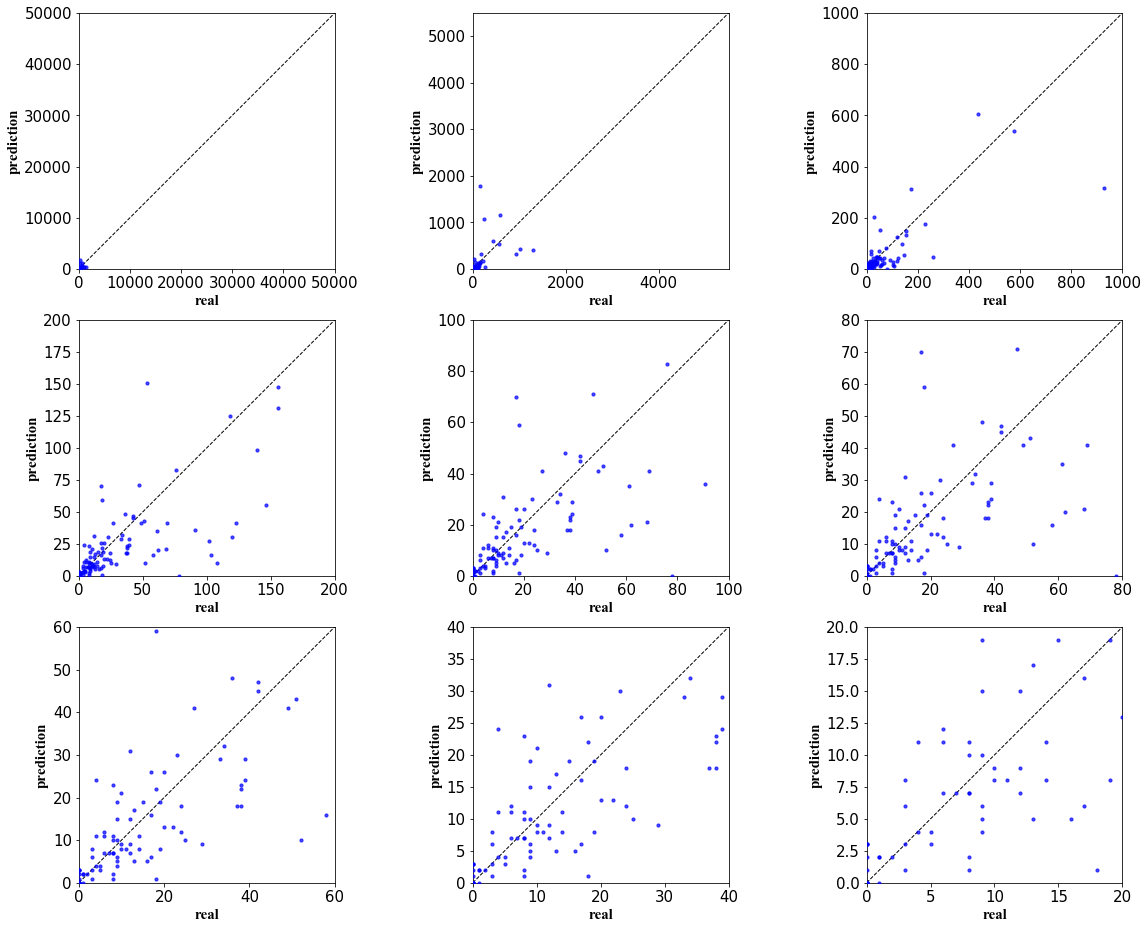

************* cv evaluation ***************
R-squared 0.9838402943553309
R 0.9918872387299531
mae 99.65096952908587
rmse 801.1648237361921


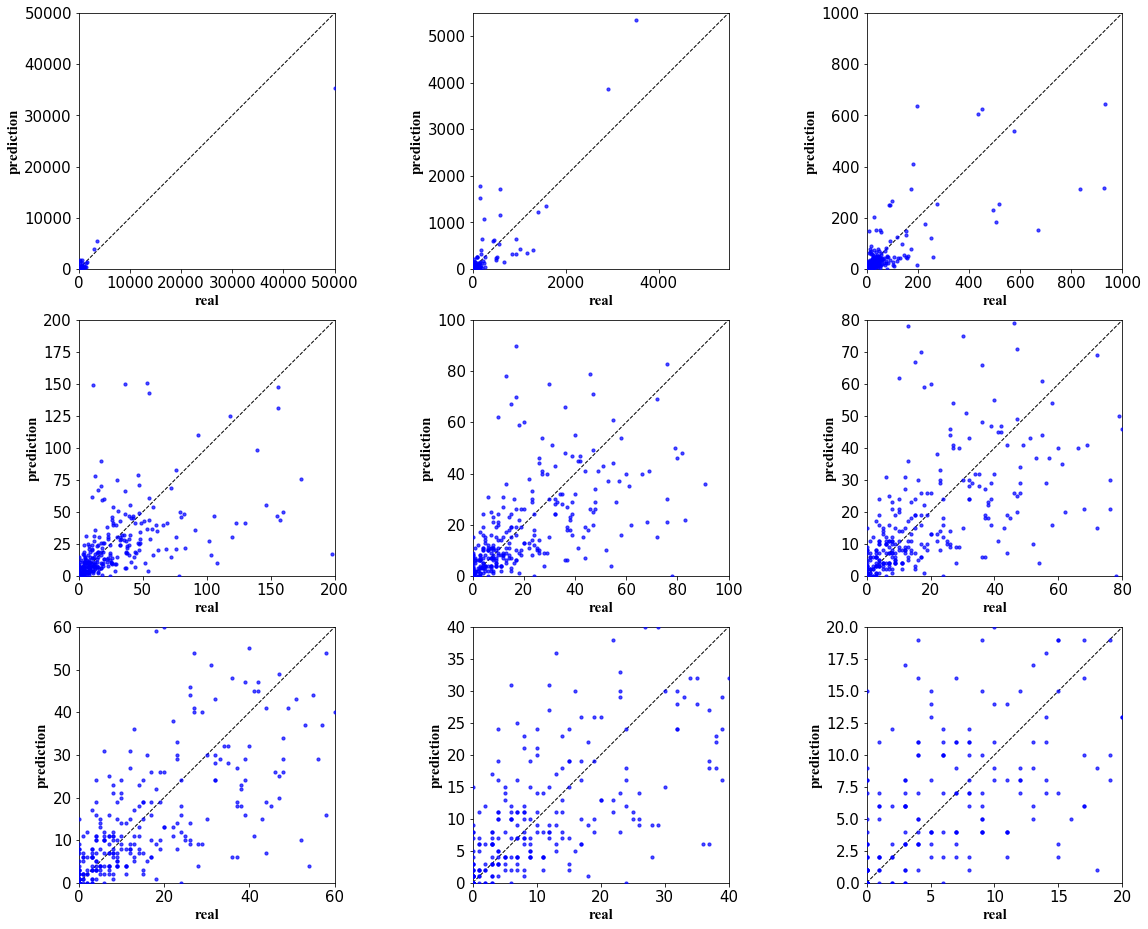

In [622]:
kf = KFold(3, True)
index = []
for train_index, test_index in kf.split(df):
    index.append((train_index, test_index))

# epidemic id 疫情灾区id，暂定武汉
epidemicIds = [420100]

# 全时间段建模
#df = df[~df['id'].isin(epidemicIds)]
case, df_predict = covid_all_predict(df, index, threshold = 50)

In [623]:
df = pd.merge(df, df_predict, how='inner', on='id')
df['diff'] = df['confirmed'] - df['predict']
df = df[df['id'].isin(case)]
df = df[['id','location','confirmed', 'predict',
    'rhMean',
    't2mMean',
    'moveInMean',
    'moveOutMea',
    'travelMean',
    'WuhanMean',
     'diff']]

In [624]:
# 预测过低的城市

# 与随机森林预测过低的结果类似，不过我不知道怎么解释，实在不懂这个模型。。。

In [625]:
df[df['diff']>0].sort_values(by='diff', ascending=False)

,id,location,confirmed,predict,rhMean,t2mMean,moveInMean,moveOutMea,travelMean,WuhanMean,diff
167,420100,武汉市,50006,35288.0,71.607512,282.498292,1.441894,2.023355,1.722975,100.000000,14718.0
178,421300,随州市,1307,396.0,70.903198,281.069625,0.238099,0.192810,2.924918,2.167692,911.0
171,420600,襄阳市,1175,337.0,71.201756,280.692857,0.499872,0.428895,3.136352,3.597582,838.0
173,420800,荆门市,928,318.0,71.598185,281.899670,0.321647,0.279806,3.208329,2.742308,610.0
168,420200,黄石市,1015,417.0,75.269348,282.796069,0.349638,0.311960,3.025581,3.193187,598.0
177,421200,咸宁市,836,312.0,76.139420,282.601893,0.329820,0.267432,3.433240,6.370220,524.0
169,420300,十堰市,672,153.0,71.845056,279.256399,0.275357,0.244492,3.025281,3.124835,519.0
88,330300,温州市,504,183.0,78.798802,284.332806,1.139140,1.407472,3.042697,0.088022,321.0
170,420500,宜昌市,931,645.0,76.941379,280.064152,0.421915,0.356423,3.151497,4.472088,286.0
182,429006,天门市,496,229.0,70.732168,282.236873,0.215931,0.166151,3.510089,1.978901,267.0


In [626]:
# 预测过高的城市
# 郑州和成都高的有些离谱

In [627]:
df[df['diff']<0].sort_values(by='diff', ascending=True)

,id,location,confirmed,predict,rhMean,t2mMean,moveInMean,moveOutMea,travelMean,WuhanMean,diff
174,420900,孝感市,3518,5349.0,71.152424,281.712290,0.581259,0.472132,2.987432,15.480989,-1831.0
149,410100,郑州市,157,1792.0,58.902450,280.062032,3.181735,3.165202,3.335111,0.483516,-1635.0
252,510100,成都市,155,1515.0,75.993469,280.945180,4.778249,5.096423,3.602126,0.277692,-1360.0
0,110000,北京市,580,1721.0,46.602664,272.940185,4.460553,4.917454,3.281025,0.467143,-1141.0
176,421100,黄冈市,2907,3858.0,73.669439,281.858747,0.785669,0.582993,3.386525,18.594066,-951.0
184,430100,长沙市,242,1068.0,78.196887,283.294240,3.008522,3.068457,3.394593,0.728791,-826.0
251,500000,重庆市,579,1159.0,77.692175,282.481705,3.243957,3.053466,3.642029,0.571319,-580.0
181,429005,潜江市,198,635.0,71.633491,282.448468,0.142624,0.125334,2.839349,1.044615,-437.0
86,330100,杭州市,181,411.0,77.657035,282.227114,3.197163,3.296147,3.844199,0.184286,-230.0
36,210100,沈阳市,28,203.0,46.205393,269.799160,1.761477,1.701233,4.103195,0.062967,-175.0


In [ ]:
# GWR训练很不稳定，cv-R2倒是很高，一直很高，都是0.9以上

# cv预测结果非常不稳定，武汉有的时候预测高的达到e10左右，其他地区（湖北等地）都上万

# 我调了很久，挑了个还算不那么离谱的结果，不过也存在很多不合理的地方，预测过低的地方很多跟武汉都没有直接联系，

In [261]:
# 管控前各个城市疫情预测
df = gp.GeoDataFrame.from_file("../shp/china_city_distinct_COVID19_before.shp")  
kf = KFold(3, True)
index = []
for train_index, test_index in kf.split(df):
    index.append((train_index, test_index))

# epidemic id 疫情灾区id，暂定武汉
epidemicIds = [420100]

# 全时间段建模
#df = df[~df['id'].isin(epidemicIds)]
case, df_predict = covid_all_predict(df, index, threshold = 20)

In [131]:
df = pd.merge(df, df_predict, how='inner', on='id')
df['diff'] = df['confirmed'] - df['predict']
df = df[df['id'].isin(case)]
df = df[['id','location','confirmed', 'predict',
    'rhMean',
    't2mMean',
    'moveInMean',
    'moveOutMea',
    'travelMean',
    'WuhanMean',
     'diff']]

In [132]:
df[df['diff']>0].sort_values(by='diff', ascending=False)

,id,location,confirmed,predict,rhMean,t2mMean,moveInMean,moveOutMea,travelMean,WuhanMean,diff
167,420100,武汉市,698,46.0,82.161216,277.927893,3.691429,6.322494,4.120335,100.000000,652.0
176,421100,黄冈市,154,46.0,82.857096,277.756878,2.274531,1.006516,4.852458,12.606538,108.0
251,500000,重庆市,110,23.0,81.690700,279.615017,6.699337,5.046055,5.064838,1.210385,87.0
173,420800,荆门市,90,26.0,79.101923,277.325860,0.786025,0.501414,5.055546,3.047308,64.0
0,110000,北京市,68,25.0,46.952353,267.598395,8.432141,13.719755,5.149477,1.179615,43.0
177,421200,咸宁市,64,25.0,86.336734,278.122550,0.928249,0.532652,5.350531,5.103462,39.0
178,421300,随州市,52,19.0,79.398717,276.382933,0.649905,0.343983,4.675454,2.953077,33.0
72,310000,上海市,53,24.0,80.613952,280.957940,6.154784,12.054880,5.327500,0.891154,29.0
88,330300,温州市,32,7.0,81.075343,283.464677,1.632216,3.456391,4.197485,0.201538,25.0


In [133]:
df[df['diff']<0].sort_values(by='diff', ascending=True)

,id,location,confirmed,predict,rhMean,t2mMean,moveInMean,moveOutMea,travelMean,WuhanMean,diff
174,420900,孝感市,100,141.0,80.659195,277.136510,1.596307,0.961099,4.722062,13.395769,-41.0
180,429004,仙桃市,12,41.0,81.704573,277.975140,0.526281,0.306374,4.384712,2.761154,-29.0
198,440100,广州市,39,67.0,71.248583,290.618403,7.572659,14.140525,3.804012,0.671154,-28.0
172,420700,鄂州市,20,47.0,83.553880,278.572922,0.605509,0.549913,4.082238,4.457692,-27.0
181,429005,潜江市,5,30.0,79.753080,277.999688,0.332992,0.221503,4.443785,1.108462,-25.0
184,430100,长沙市,22,43.0,85.910260,279.149545,4.208644,6.180231,4.447612,1.194231,-21.0


In [ ]:
# 管控前预测过高和过低的情况与全时间段基本类似
df = gp.GeoDataFrame.from_file("../shp/china_city_distinct_COVID19_after.shp")
    
kf = KFold(3, True)
index = []
for train_index, test_index in kf.split(df):
    index.append((train_index, test_index))

# 全时间段建模
#df = df[~df['id'].isin(epidemicIds)]
case, df_predict = covid_all_predict(df, index, threshold=50)

In [138]:
df = pd.merge(df, df_predict, how='inner', on='id')
df['diff'] = df['confirmed'] - df['predict']
df = df[df['id'].isin(case)]
df = df[['id','location','confirmed', 'predict',
    'rhMean',
    't2mMean',
    'moveInMean',
    'moveOutMea',
    'travelMean',
    'WuhanMean',
     'diff']]

In [ ]:
# 管控后预测过高和过低的情况与全时间段基本类似

In [139]:
df[df['diff']>0].sort_values(by='diff', ascending=False)

,id,location,confirmed,predict,rhMean,t2mMean,moveInMean,moveOutMea,travelMean,WuhanMean,diff
167,420100,武汉市,49308,597.0,67.548395,284.256138,0.542080,0.303700,0.764031,100.000000,48711.0
174,420900,孝感市,3418,880.0,67.495974,283.472206,0.175240,0.276545,2.293580,16.315077,2538.0
176,421100,黄冈市,2753,1391.0,70.135725,283.436388,0.190124,0.413585,2.800152,20.989077,1362.0
178,421300,随州市,1255,462.0,67.635691,282.872199,0.073377,0.132341,2.224703,1.853538,793.0
175,421000,荆州市,1533,803.0,69.231072,284.337159,0.237780,0.419148,2.643878,6.812923,730.0
172,420700,鄂州市,1374,725.0,68.977774,284.789154,0.080072,0.096943,1.504028,5.203231,649.0
88,330300,温州市,472,30.0,77.923209,284.666702,0.941910,0.587904,2.580782,0.042615,442.0
0,110000,北京市,512,89.0,46.468169,274.994719,2.871917,1.396534,2.533645,0.182154,423.0
171,420600,襄阳市,1139,745.0,67.982955,282.419131,0.180650,0.282184,2.327737,3.511538,394.0
72,310000,上海市,463,154.0,70.698488,283.184662,3.597767,1.888296,3.434394,0.299231,309.0


In [140]:
df[df['diff']<0].sort_values(by='diff', ascending=True)

,id,location,confirmed,predict,rhMean,t2mMean,moveInMean,moveOutMea,travelMean,WuhanMean,diff
179,422800,恩施土家族苗族自治州,227,825.0,78.710185,281.009652,0.157376,0.257877,3.280932,5.884308,-598.0
181,429005,潜江市,193,728.0,68.510573,284.159537,0.066477,0.086867,2.197575,1.019077,-535.0
182,429006,天门市,483,905.0,67.397417,283.935709,0.077401,0.139474,2.915722,2.029385,-422.0
180,429004,仙桃市,563,969.0,68.048552,284.140160,0.079986,0.113498,2.243594,3.041692,-406.0
149,410100,郑州市,128,367.0,54.497972,282.009780,2.365988,1.453476,2.633251,0.407385,-239.0
184,430100,长沙市,220,422.0,75.230205,284.888353,2.528474,1.823747,2.973386,0.542615,-202.0
161,411300,南阳市,137,285.0,62.697251,281.920763,0.401780,0.791422,3.071334,0.349231,-148.0
185,430200,株洲市,75,210.0,77.636058,285.841944,0.554582,0.612216,3.463406,0.298769,-135.0
214,441900,东莞市,98,215.0,73.799657,292.110542,4.424677,2.442916,2.284398,0.179231,-117.0
125,360400,九江市,114,191.0,75.150334,284.121798,0.328033,0.535635,3.361745,0.301692,-77.0


In [141]:
# 总结

# 预测过低的情况——实际确诊人数在50~600，预测人数严重偏低，均在100以下，甚至接近于0，这类城市的WuhanMean极低，接近于0

# 预测过高的情况——实际确诊人数在200以下，预测城市确诊人数严重偏高，均在300以上，甚至接近于1000，这类城市的WuhanMean较高

## 以上两种情况推测百度迁徙指数数据存在误差，比如温州；
## 很多城市与武汉没有直接联系，这类情况考虑补充与省会的迁徙，更好的表达方式或许还是图卷积
## 目前筛选的特征并不能完全表征城市，存在一些城市特征很接近，但是label差异较大，这类情况模型只能做折中处理，无法偏向任何一方

### 在计算cv的r2时，要不要把武汉去掉来计算，或者建模的时候把它扔掉？？？那样结果倒是好看很多😁